In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
from portopt import min_profit_multi_scale as getport

In [3]:
from ortools.linear_solver import pywraplp

def get_sigma(t, memory, df, times):
    H = len(times)
    sigma = []
    for h in range(H):
        memory_real = df[h]['metric'][t - times[h] - memory: t - times[h]]
        sigma.append(np.var(np.array(memory_real)))
    return sigma
        
def simulate(df, times, step, memory, shift = 0):
    H = len(df)
    T = len(df[0])
    t = memory + max(times) + shift
    money = 1
    coins = 0
    price = 0
    s = 0.001
    counter = 1000
    record = []

    while(t < T and money + price * coins > 0):
        sigma = get_sigma(t, memory, df, times)
        r = [df[h]['preds'][t] for h in range(H)]
        price = df[0]['midpoint'][t]
    
        money =  money + price * coins
        w0 = price * coins / money
        coins = 0
        w0 = getport(w0 = w0, r = r, sigma = sigma, s = s)
        record.append([t, money, price, w0])
            
        if(counter * step > 10000):
            print(np.ceil(t/10000) - 1,'/',np.ceil(T/10000),' money =', money, ' w0 =', w0)
            counter = 0
        counter += 1
        
        coins = w0 * money / price
        money = (1 - w0) * money
        t += step

    record = np.array(record).T    
    money += price * coins
    print('Final: money =', money)
    return record

In [7]:
times = [15, 60, 180, 720]
df = [pl.read_parquet("btc-augfeb-ema-eth-feat-select-v3/" + str(t) + ".pq") for t in times]

step = 15
memory_time = 60 * 24
record = [simulate(df, times, step, memory_time, shift = shift)[0:3] for shift in range(step)]

0.0 / 26.0  money = 1.0  w0 = 0.0
1.0 / 26.0  money = 1.0628879278729995  w0 = 0.0
2.0 / 26.0  money = 1.0216296282849753  w0 = 1.0
3.0 / 26.0  money = 1.027901503194209  w0 = 1.0
4.0 / 26.0  money = 1.0605355734102788  w0 = 0.0
5.0 / 26.0  money = 1.0948637930424316  w0 = 0.0
6.0 / 26.0  money = 1.1046062598333208  w0 = 0.0
7.0 / 26.0  money = 1.1735298166904422  w0 = 0.0
8.0 / 26.0  money = 1.2031564730233386  w0 = 0.0
9.0 / 26.0  money = 1.2495709438710125  w0 = 0.0
10.0 / 26.0  money = 1.2640357030594582  w0 = 0.0
11.0 / 26.0  money = 1.294021197158073  w0 = 0.0
12.0 / 26.0  money = 1.29255119088734  w0 = 0.0
13.0 / 26.0  money = 1.3228134458522198  w0 = 0.0
14.0 / 26.0  money = 1.115634155306849  w0 = 1.0
15.0 / 26.0  money = 1.0916578985657426  w0 = 1.0
16.0 / 26.0  money = 1.0865449902719222  w0 = 1.0
17.0 / 26.0  money = 1.1308169466835343  w0 = 0.0
18.0 / 26.0  money = 1.1498221781705948  w0 = 1.0
19.0 / 26.0  money = 1.145842068961893  w0 = 1.0
20.0 / 26.0  money = 1.13670462

4.318388576476578


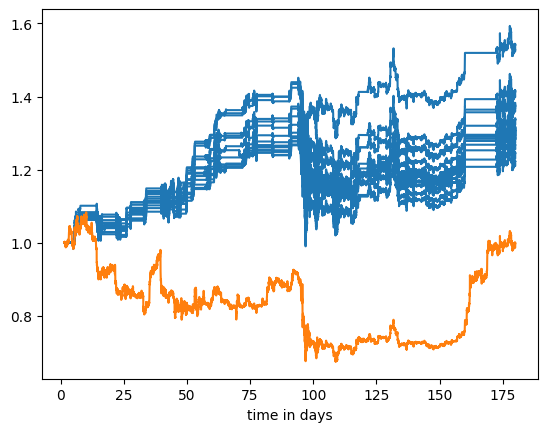

In [9]:
color = 'tab:blue'
plt.xlabel('time in days')
for dataset in record:
    x = dataset[0]
    y = dataset[1]
    plt.plot(x / 60 / 24, y, color = color)

color = 'tab:orange'
plt.plot(record[0][0] / 60 / 24, record[0][2] / record[0][2][0], color = color, label = 'coin price')
a = [dataset[1][-1] for dataset in record]
print((np.mean(a) - 1)/np.sqrt(np.var(a)))